# О проекте

В строительной компании ведётся цифровой учёт заявок на поставку бетона через Google Forms. Все заявки автоматически сохраняются в Google Таблицу, где также фиксируется информация об исполнении — фактическая дата поставки, объём, отклонения и прочие параметры. Сбор данных ведётся с июня 2024 года, и на текущий момент накоплен достаточный объём информации для проведения анализа и построения предиктивной модели.

В процессе поставок периодически возникают задержки: бетон может быть доставлен на строительную площадку с опозданием на один или несколько дней. Цель проекта — разработать модель машинного обучения, которая будет предсказывать вероятность задержки в поставке бетона.

Возможны два подхода:

* **Классификация** — модель предсказывает факт задержки (да/нет);
* **Регрессия** — модель предсказывает количество дней задержки (если она будет).

Модель позволит заранее выявлять риск отклонений от графика и своевременно принимать управленческие решения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    f1_score, 
    confusion_matrix, 
    roc_auc_score, 
    classification_report, 
    recall_score, 
    ConfusionMatrixDisplay
)
from lightgbm import LGBMClassifier
import re

**Источники данных**  

Таблица заявок — автоматически формируется из Google Forms и содержит исходную информацию о заказе бетона.  

Отчёт по поставкам — агрегированная таблица, где фиксируются фактические результаты исполнения заявок.  

Таблица заявок 2 — фактически новая таблица заявок, которая стала формироваться после перехода компании на React-приложение. Она заменила предыдущий источник (Google Forms) для ввода данных и теперь является основной точкой сбора информации о заказах бетона.  


In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQYF7LcaaZJQNEdQ502p8vkRTnvXn2xUHENQdTwRL2zOgM26uAgnyfgxvbzjZVE7eY0W99Somk5FhTd/pub?gid=655205162&single=true&output=csv')
df.head(2)

,Отметка времени,Выберите дату доставки,Укажите время доставки на объект или нажмите далее,Выберите тип строительства,Выберите объект,Выберите объект.1,Укажите конструктив,Выберите объект.2,Выберите конструкцию,Выберите объект.3,...,Выберите марку раствора,Выберите класс бетона,Выберите подвижность бетона,Укажите необходимый объём; м3,ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),Выберите позицию.2,Unnamed: 42,Выберите конструкцию,Выберите конструкцию.3
0,06.06.2024 12:09:28,07.06.2024,8:00,Здание,NaN,NaN,NaN,NaN,NaN,СПОРТ,...,NaN,В 25,П4,90,Адаменко О.Ю.,87771456752,NaN,NaN,NaN,NaN
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,В 15,П3,3,Нуршабаев Манат,7763030297,NaN,NaN,NaN,NaN


In [3]:
df[df['Отметка времени'].isna()].head(2)

,Отметка времени,Выберите дату доставки,Укажите время доставки на объект или нажмите далее,Выберите тип строительства,Выберите объект,Выберите объект.1,Укажите конструктив,Выберите объект.2,Выберите конструкцию,Выберите объект.3,...,Выберите марку раствора,Выберите класс бетона,Выберите подвижность бетона,Укажите необходимый объём; м3,ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),Выберите позицию.2,Unnamed: 42,Выберите конструкцию,Выберите конструкцию.3
762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.dropna(how='all').reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 45 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   Отметка времени                                     4913 non-null   object
 1   Выберите дату доставки                              4913 non-null   object
 2   Укажите время доставки на объект или нажмите далее  3938 non-null   object
 3   Выберите тип строительства                          4907 non-null   object
 4   Выберите объект                                     364 non-null    object
 5   Выберите объект.1                                   1241 non-null   object
 6   Укажите конструктив                                 1591 non-null   object
 7   Выберите объект.2                                   165 non-null    object
 8   Выберите конструкцию                                165 non-null    object
 9   Выберите

In [6]:
df.shape

(4913, 45)

In [7]:
def first_nonempty_by_prefix(df, prefix, out_col):
    cols = df.filter(regex=rf'^{re.escape(prefix)}(?:\.\d+)?$').columns
    tmp = (df[cols].astype('string')
           .apply(lambda s: s.str.strip())
           .replace({'': np.nan, 'nan' : np.nan}))
    df[out_col] = tmp.bfill(axis=1).iloc[:, 0].fillna('')

In [8]:
first_nonempty_by_prefix(df, 'Выберите объект', 'object')
first_nonempty_by_prefix(df, 'Выберите позицию', 'position')
first_nonempty_by_prefix(df, 'Выберите блок', 'block')
first_nonempty_by_prefix(df, 'Выберите конструкцию', 'constructive')
first_nonempty_by_prefix(df, 'Выберите этаж', 'этаж')

In [9]:
df['material_class'] = (df['Выберите марку раствора'].fillna('') + 
                        df['Выберите класс бетона'].fillna(''))

In [10]:
keep_cols = [
    'Отметка времени',
    'Выберите дату доставки',
    'Укажите время доставки на объект или нажмите далее',
    'Выберите тип строительства',
    'Выберите материал',
    'Выберите подвижность бетона',
    'Укажите необходимый объём; м3',
    'ФИО (ответственного за приёмку бетона)',
    'Телефон (ответственного за приёмку бетона)',
    'object',
    'position',
    'block',
    'constructive',
    'этаж',
    'material_class'
]
df_filtered_columns = df[keep_cols]
df_filtered_columns.head(2)

,Отметка времени,Выберите дату доставки,Укажите время доставки на объект или нажмите далее,Выберите тип строительства,Выберите материал,Выберите подвижность бетона,Укажите необходимый объём; м3,ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),object,position,block,constructive,этаж,material_class
0,06.06.2024 12:09:28,07.06.2024,8:00,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,,8 этаж,В 25
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,,,В 15


In [11]:
df_filtered_columns = df_filtered_columns.rename(columns={
    'Отметка времени' : 'application_submission_datetime',
    'Выберите дату доставки' : 'planned_delivery_date',
    'Укажите время доставки на объект или нажмите далее' : 'planned_delivery_time',
    'Выберите тип строительства' : 'type',
    'Выберите материал' : 'material',
    'Выберите подвижность бетона' : 'mobility',
    'Укажите необходимый объём; м3' : 'volume',
    'ФИО (ответственного за приёмку бетона)' : 'full_name',
    'Телефон (ответственного за приёмку бетона)' : 'phone',
    'этаж' : 'floor'    
})

In [12]:
df_2 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQYF7LcaaZJQNEdQ502p8vkRTnvXn2xUHENQdTwRL2zOgM26uAgnyfgxvbzjZVE7eY0W99Somk5FhTd/pub?gid=61989395&single=true&output=csv')
df_2.head(2)

,Дата и время подачи заявки,Дата доставки бетона,Время доставки бетона,Объект,"Блок, позиция",Материал,"Марка, класс",Подвижность,"Объём, м3",ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),Дата отгрузки,Фактический объём,Отметка о исполнении,Согласование геодезистов,Категория,Согласование энергетиков
0,06.06.2024 12:09:28,07.06.2024,8:00,СПОРТ,поз.74 8 этаж Вертикал,Бетон,В 25,П4,90,Адаменко О.Ю.,87771456752,NaN,NaN,Отменено,NaN,СМР,NaN
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство Школа (Нурлы Жол),NaN,Бетон,В 15,П3,3,Нуршабаев Манат,7763030297,07.06.2024,3,Исполнено,NaN,СМР,NaN


In [13]:
cols = ['Дата и время подачи заявки','Дата отгрузки','Фактический объём',
        'Отметка о исполнении','Согласование геодезистов','Категория',
        'Согласование энергетиков']
df_report1 = df_2[cols]
df_report1.head(2)

,Дата и время подачи заявки,Дата отгрузки,Фактический объём,Отметка о исполнении,Согласование геодезистов,Категория,Согласование энергетиков
0,06.06.2024 12:09:28,NaN,NaN,Отменено,NaN,СМР,NaN
1,06.06.2024 15:26:16,07.06.2024,3,Исполнено,NaN,СМР,NaN


In [14]:
df_report1 = df_report1.drop(columns='Категория', axis=1)

In [15]:
df_report1 = df_report1.rename(columns={
    'Дата и время подачи заявки' : 'application_submission_datetime',
    'Дата отгрузки' : 'delivery_date',
    'Фактический объём' : 'actual_volume',
    'Отметка о исполнении' : 'completion_status',
    'Согласование геодезистов' : 'surveyors_approval',
    'Согласование энергетиков' : 'power_approval'
})   

In [16]:
df_merged = pd.merge(df_filtered_columns, df_report1, on='application_submission_datetime', how='outer')

In [17]:
df_merged['mobility'].unique()

array([nan, 'П3', 'П4'], dtype=object)

In [18]:
df_3 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTSu48SFcG0-dZpjkW3Z3uN3jJF0QPkpFUroD1YHWRj_8jy7ZwND096Rgd60fDiQGPHMOY8TDVy-_fl/pub?output=csv')

In [19]:
df_3 = df_3.rename(columns={
    'Дата и время подачи заявки' : 'application_submission_datetime',
    'Дата' : 'planned_delivery_date',
    'Время' : 'planned_delivery_time',
    'Категория' : 'type',
    'Объект' : 'object',
    'Позиция' : 'position',
    'Блок' : 'block',
    'Этаж' : 'floor',
    'Конструктив' : 'constructive',
    'Материал' : 'material',
    'Подвижность' : 'mobility',
    'Количество' : 'volume',
    'ФИО' : 'full_name',
    'Телефон' : 'phone',
    'Дата отгрузки' : 'delivery_date',
    'Фактический объём' : 'actual_volume',
    'Отметка о исполнении' : 'completion_status',
    'Согласование геодезистов' : 'surveyors_approval',
    'Согласование энергетиков\n(только в зимний период)' : 'power_approval',
    'Марка' : 'material_class'
    
})

In [20]:
df_3['planned_delivery_date'] = pd.to_datetime(df_3['planned_delivery_date'], format='%Y-%m-%d')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   application_submission_datetime  1236 non-null   object        
 1   planned_delivery_date            1236 non-null   datetime64[ns]
 2   planned_delivery_time            1236 non-null   object        
 3   type                             1236 non-null   object        
 4   object                           1236 non-null   object        
 5   position                         1236 non-null   object        
 6   block                            637 non-null    object        
 7   floor                            637 non-null    object        
 8   constructive                     637 non-null    object        
 9   material                         1236 non-null   object        
 10  material_class                   1236 non-null   object     

In [21]:
df_3 = df_3.drop(columns='Примечание', axis=1)

In [22]:
df_full = pd.concat([df_merged, df_3], ignore_index=True)
df_full.shape

(6167, 20)

In [23]:
df_completed = df_full[df_full['completion_status'] == 'Исполнено'].copy().reset_index(drop=True)
df_completed.shape 

(5592, 20)

In [24]:
df_completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5592 entries, 0 to 5591
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   application_submission_datetime  5592 non-null   object
 1   planned_delivery_date            5592 non-null   object
 2   planned_delivery_time            4707 non-null   object
 3   type                             5584 non-null   object
 4   material                         5592 non-null   object
 5   mobility                         3509 non-null   object
 6   volume                           5592 non-null   object
 7   full_name                        5582 non-null   object
 8   phone                            5566 non-null   object
 9   object                           5592 non-null   object
 10  position                         5592 non-null   object
 11  block                            5040 non-null   object
 12  constructive                     5

In [25]:
df_completed['planned_delivery_time'] = (df_completed['planned_delivery_time']
                                                .str.split(' ')
                                                .str[0])

df_completed['planned_delivery_time'] = df_completed['planned_delivery_time'].str.split('(').str[0]
df_completed['planned_delivery_time'] = df_completed['planned_delivery_time'].str.replace(r'[-=*_"]', ':', regex=True)
df_completed['planned_delivery_time'] = (df_completed['planned_delivery_time']
                                                .replace(['', '8.06.2024', '9.06.2024','Нурлы','С',
                                                          'По', '29.06.2024', '08,07,2024', 'В','Школа',
                                                          '06,08,2024', 'Комфортная', '14.08.2024',
                                                          '15.08.2024', '4.09.2024', '6.09.2024',
                                                          'Детский', 'Азимхан', 'Глубоковский',
                                                          '28,10,2024', '29.10.2024', '1.11.2024',
                                                          'Манат','НЖ3', 'Кирпичный',
                                                          '45','1,5', 'Новоявленке'], np.nan))
df_completed['planned_delivery_time'] = df_completed['planned_delivery_time'].str.replace(r'[.]', ':', regex=True)
df_completed['planned_delivery_time'] = (df_completed['planned_delivery_time']
                                                .replace({'800' : '8:00', 
                                                          '1300' : '13:00', 
                                                          'в8:00' : '8:00', 
                                                          'В8:00' : '8:00',
                                                          'в' : np.nan, 
                                                          ',9:00' : '9:00', 
                                                          '0,75' : np.nan, 
                                                          '830' : '8:30',
                                                          '111' : '11:00', 
                                                          '1400' : '14:00',
                                                          '1600' : '16:00', 
                                                          '1,3' : '13:30', 
                                                          '900' : '9:00', 
                                                          '1000' : '10:00', 
                                                          '1500' : '15:00',
                                                          '0900' : '9:00'}))

df_completed['planned_delivery_time'] = df_completed['planned_delivery_time'].str.split(r'[:,;]').str[0]
df_completed['planned_delivery_time'] = (df_completed['planned_delivery_time']
                                                .replace({'08' : '8', 
                                                          '09' : '9', 
                                                          '00' : np.nan, 
                                                          '07' : '7',
                                                          '4' : '16',
                                                          '3' : '15',
                                                          '5' : '17'}))

mode_hours = df_completed['planned_delivery_time'].mode()[0]
df_completed['planned_delivery_time'] = df_completed['planned_delivery_time'].fillna(mode_hours)

In [26]:
df_completed[['application_submission_date', 'application_submission_time']] = (df_completed['application_submission_datetime']
                                                                             .str.split(' ', expand=True))
df_completed['application_submission_time'] = df_completed['application_submission_time'].str.split(':').str[0]
df_completed = df_completed.drop(columns='application_submission_datetime', axis=1)

In [27]:
df_completed['planned_delivery_date'] = pd.to_datetime(
    df_completed['planned_delivery_date'], 
    dayfirst=True
)
df_completed['delivery_date'] = (
    df_completed['delivery_date']
        .astype(str)
        .str.replace(
            r'(\d{2}[\.\-]\d{2}[\.\-])0\d(\d{2})',  
            r'\g<1>20\2',                           
            regex=True)
    .pipe(pd.to_datetime, dayfirst=True, errors='coerce')
)
df_completed['delivery_date'] = pd.to_datetime(
    df_completed['delivery_date'], 
    dayfirst=True
)
df_completed['planned_delivery_time'] = pd.to_numeric(
    df_completed['planned_delivery_time']
)
df_completed['volume'] = (
    df_completed['volume']
    .str.replace(',', '.')
    .str.replace('м3', '')
    .str.replace(' ', '')
)
df_completed['volume'] = pd.to_numeric(
    df_completed['volume'], 
    errors='coerce'
)
df_completed['actual_volume'] = (
    df_completed['actual_volume']
    .str.replace(',','.')
)
df_completed['actual_volume'] = pd.to_numeric(
    df_completed['actual_volume']
)
df_completed['application_submission_date'] = pd.to_datetime(
    df_completed['application_submission_date'],
    dayfirst=True
)
df_completed['application_submission_time'] = pd.to_numeric(
    df_completed['application_submission_time']
)

In [28]:
tab = df_completed.loc[df_completed['full_name'].str.contains('алинов', case=False, na=False, regex=False)]
tab[tab['type'].str.contains('реализация', case=False, na=False, regex=False)]

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,...,constructive,floor,material_class,delivery_date,actual_volume,completion_status,surveyors_approval,power_approval,application_submission_date,application_submission_time
2456,2025-06-17,8,Реализация на сторону,Бетон,П4,4.5,Алинов,87051854684,,,...,,,В 25,2025-06-17,4.5,Исполнено,NaN,NaN,2025-06-17,11
2467,2025-06-18,8,Реализация на сторону,Бетон,П3,5.0,Алинов,87051854684,,,...,,,В 25,2025-06-18,7.2,Исполнено,NaN,NaN,2025-06-17,16


In [29]:
df_completed.loc[
(df_completed['full_name'] == 'Алинов') &
(df_completed['type'] == 'Реализация на сторону'),
'full_name'
] = 'реализация'

In [30]:
df_completed[df_completed['type'].isna()]

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,...,constructive,floor,material_class,delivery_date,actual_volume,completion_status,surveyors_approval,power_approval,application_submission_date,application_submission_time
3948,2024-06-30,8,NaN,Раствор,NaN,397.0,NaN,NaN,Разница м/у эл.журналом и отчётом БРУ,,...,,,,NaT,397.0,Исполнено,NaN,NaN,2024-11-27,0
4315,2024-06-30,8,NaN,Бетон,NaN,3468.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-06-30,3468.0,Исполнено,NaN,NaN,2024-06-30,0
4360,2024-09-30,8,NaN,Раствор,NaN,33.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-09-30,33.0,Исполнено,NaN,NaN,2024-09-30,0
4427,2024-07-31,8,NaN,Бетон,NaN,244.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-07-31,244.0,Исполнено,NaN,NaN,2024-07-31,0
4428,2024-07-31,8,NaN,Бетон,NaN,244.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-07-31,31.0,Исполнено,NaN,NaN,2024-07-31,0
4429,2024-07-31,8,NaN,Раствор,NaN,31.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-07-31,244.0,Исполнено,NaN,NaN,2024-07-31,0
4430,2024-07-31,8,NaN,Раствор,NaN,31.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-07-31,31.0,Исполнено,NaN,NaN,2024-07-31,0
4443,2024-08-31,8,NaN,Раствор,NaN,47.0,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,...,,,,2024-08-31,47.0,Исполнено,NaN,NaN,2024-08-31,0


In [31]:
# Отбираем только фактические заявки, исключая строки корректировки 
# разницы м/у эл.заявкой и отчётом бру и "Общий за месяц"
df_actual_requests = (
    df_completed[
    (~df_completed['type'].isna()) & 
    (df_completed['object'] != 'Общий за месяц')
    ]
    .copy()
)
df_actual_requests.head(2)

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,...,constructive,floor,material_class,delivery_date,actual_volume,completion_status,surveyors_approval,power_approval,application_submission_date,application_submission_time
0,2025-02-02,8,Здание,Раствор,NaN,0.5,Адаменко О.Ю.,87771456752,СПОРТ,поз.76,...,,6 этаж,М 100,2025-02-02,0.5,Исполнено,NaN,NaN,2025-02-01,19
1,2025-02-01,8,Здание,Раствор,NaN,1.5,Дүйсен Ільяс Ержанұлы,87779917588,Brick Town,,...,,2 этаж,М 100,2025-02-01,1.5,Исполнено,NaN,NaN,2025-02-01,7


In [33]:
df_actual_requests.loc[:, 'type'] = (
    df_actual_requests['type']
    .str.lower()
)
df_actual_requests.loc[:, 'type'] = (
    df_actual_requests['type']
    .replace('строительство и реконструкция коммерческих,' 
             'частных и туристических объектов', 
             'коммерческие объекты')
    .replace('благоустройство', 
             'строительство сетей и благоустройство')
    .replace('инженерные сети', 
             'строительство сетей и благоустройство')
    .replace('жби', 
             'производственные объекты')
)
df_actual_requests['type'].unique()

array(['здание', 'коммерческие объекты', 'здания',
       'производственные объекты',
       'строительство сетей и благоустройство', 'реализация на сторону',
       'строительство жилых домов',
       'строительство и реконструкция коммерческих, частных и туристических объектов',
       'строительство объектов инфраструктуры (кроме жилых домов)',
       'строительство и ремонт дорог', 'гарантийные работы'], dtype=object)

In [34]:
df_actual_requests['position'] = (
    df_actual_requests['position']
    .replace('', np.nan)
)

In [36]:
df_actual_requests['position'] = (
    df_actual_requests['position']
    .fillna(df_actual_requests['object'])
)

In [37]:
df_actual_requests['object'] = (
    df_actual_requests['object']
    .str.lower()
    .str.replace(r'.*(абк|явленк).*', 'новоявленка', regex=True)
    .str.replace(r'.*(бру|базовавя 5|базовая 5).*', 'бру', case=False, regex=True)
    .str.replace(r'.*\bжби\b.*', 'цех жби', case=False, regex=True)
    .str.replace(r'.*\bдвд\b.*', 'прочие', case=False, regex=True)
    .str.replace(r'(?i).*(эко|паркинг).*', 'экополис', case=False, regex=True)
    .str.replace(r'(?i).*карьер.*', 'карьеры', case=False, regex=True)
    .str.replace(r'(?i).*(бизнес|ТЦ\s*Победы).*', 'бизнес центр пр.победы', case=False, regex=True)
    .str.replace(r'(?i).*автомо.*', 'коммерческие объекты', case=False, regex=True) 
    .str.replace(r'^цех.*', 'цех жби', case=False, regex=True)
    .str.replace(r'(?i).*кирзавод.*', 'кирзавод', case=False, regex=True)
    .str.replace(r'(?i).*коллектор.*', 'инженерные сети', case=False, regex=True)
    .str.replace(r'(?i).*лаб.*', 'ветлаборатория', case=False, regex=True)
    .str.replace(r'(?i).*развязка.*', 'развязка', case=False, regex=True)
    .str.replace(r'(?i).*инженерные сети.*', 'инженерные сети', case=False, regex=True)
    .str.replace(r'(?i).*благоустройство.*', 'благоустройство', case=False, regex=True)
    .str.replace(r'(?i).*клюшки.*', 'нурлы жол 1-2', case=False, regex=True)
    .str.replace(r'(?i).*дсу.*', 'реализация', case=False, regex=True)
    .str.replace(r'(?i).*(ульбинка|орл[её]нок).*', 'горная ульбинка', case=False, regex=True)
    .str.replace(r'(?i).*(базовая, 3|база эскор).*', 'база эскор', case=False, regex=True)
    .str.replace(r'(?i).*(металлоцех|пропарочная|центральн).*', 'база самарское', case=False, regex=True)
    .str.replace(r'(?i).*(колледж|лицей|каток|школа).*', 'учебные заведения', case=False, regex=True)
    .str.replace(r'(?i).*(royal b|кренделия).*', 'коммерческие объекты', case=False, regex=True)
    .str.replace(r'(?i).*(гараж|урунтаева|мурагер).*', 'прочие', case=False, regex=True)
    .replace({
        '' : 'реализация',
        'brick town' : 'брик таун 1',
        'brick town 2' : 'брик таун 2',
        'спорт 2' : 'спорт',
        'очистные сооружения' : 'кос',
        'нұр тау' : 'нуртау',
        'нур-тау' : 'нуртау',
        'гараж (на комсомольском)' : 'гараж',
        'нурлы жол 3' : 'нж 3',
        'тп' : 'инженерные сети',
        'ктп 72 поз' : 'инженерные сети',
    })
)

In [38]:
df_actual_requests['position'] = (
    df_actual_requests['position']
    .str.lower()
    .str.replace(r'.*(абк|явленк).*', 'комбинат пгс', regex=True)
    .str.replace(r'.*(бру|базовавя 5|базовая 5).*', 'бру', case=False, regex=True)
    .str.replace(r'.*(^brick|пятно).*', 'не указано', case=False, regex=True)
    .str.replace(r'.*\bжби\b.*', 'цех жби', case=False, regex=True)
    .str.replace(r'.*\bдвд\b.*', 'прочие', case=False, regex=True)
    .str.replace(r'(?i).*(эко|паркинг|жилой дом поз.74|поз.75|жилой дом. поз.73|103|104|105).*', 
                 'экополис', case=False, regex=True)
    .str.replace(r'(?i).*(бизнес|ТЦ\s*Победы|здание атц).*', 'бизнес центр пр.победы', case=False, regex=True)
    .str.replace(r'(?i).*автомо.*', 'автомойка (нурлы жол)', case=False, regex=True) 
    .str.replace(r'^цех.*', 'цех жби', case=False, regex=True)
    .str.replace(r'(?i).*кирзавод.*', 'кирзавод', case=False, regex=True)
    .str.replace(r'(?i).*лаб.*', 'ветлаборатория', case=False, regex=True)
    .str.replace(r'(?i).*развязка.*', 'развязка', case=False, regex=True)
    .str.replace(r'(?i).*инженерные сети.*', '', case=False, regex=True)
    .str.replace(r'(?i).*благоустройство.*', '', case=False, regex=True)
    .str.replace(r'(?i).*клюшки.*', 'нурлы жол 1-2', case=False, regex=True)
    .str.replace(r'(?i).*дсу.*', 'реализация', case=False, regex=True)
    .str.replace(r'(?i).*ульбинка.*', 'горная ульбинка', case=False, regex=True)
    .str.replace(r'(?i).*(базовая, 3|база эскор).*', 'база эскор', case=False, regex=True)
    .str.replace(r'(?i).*(металлоцех|центральн).*', 'не указано', case=False, regex=True)
    .str.replace(r'(?i).*колледж.*', 'лицей', case=False, regex=True)
    .str.replace(r'(?i).*каток.*', 'ледовый каток', case=False, regex=True)
    .str.replace(r'(?i).*(гараж|урунтаева|мурагер).*', 'прочие', case=False, regex=True)
    .replace({
        'орлёнок' : 'орленок',
        'карьер жансат' : 'карьер',
        'клюшки' : 'не указано',
        'клюшки поз 53' : 'поз.53',
        'очистные сооружения' : 'кос',
        'нұр тау' : 'нуртау',
        'нур-тау' : 'нуртау',
        'квартальные инженерные сети теплоснабжения, водоснабжения и водоотведения (нурлы жол 3)' : 'сети ов вк нж3',
        'квартальные инженерные сети теплоснабжения, водоснабжения и водоотведения (спорт)' : 'сети ов вк спорт',
        'благоустройство нурлы жол 3' : 'благоустройство нж3',
        'ктп 72 поз' : 'эл нж3',
        'тп' : 'эл нж3',
    })
)

In [39]:
df_actual_requests = df_actual_requests.drop(columns='completion_status')
df_actual_requests.head(2)

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,delivery_date,actual_volume,surveyors_approval,power_approval,application_submission_date,application_submission_time
0,2025-02-02,8,здание,Раствор,NaN,0.5,Адаменко О.Ю.,87771456752,спорт,поз.76,,,6 этаж,М 100,2025-02-02,0.5,NaN,NaN,2025-02-01,19
1,2025-02-01,8,здание,Раствор,NaN,1.5,Дүйсен Ільяс Ержанұлы,87779917588,брик таун 1,не указано,9/1,,2 этаж,М 100,2025-02-01,1.5,NaN,NaN,2025-02-01,7


In [40]:
KZ2RU = {
    'ә':'а', 'ғ':'г', 'қ':'к', 'ң':'н',
    'ө':'о', 'ұ':'у', 'ү':'у', 'һ':'х', 'і':'и',
}

PAT = re.compile('|'.join(KZ2RU.keys()))
PAT

re.compile(r'ә|ғ|қ|ң|ө|ұ|ү|һ|і', re.UNICODE)

In [44]:
pattern = (
    r'(?i).*(qazcon|дсу|энтуз|оскемен|развед|риж|славск|фирма|'
    r'частн|ганжиев|леванев|пескаб|плахуты|носик|ахметова|векай|'
    r'вейкай|садуакасов|сидоров|эльдар|касенов).*'
)

df_actual_requests['full_name'] = (
    df_actual_requests['full_name']
    .str.split(' ', n=1, expand=True)[0]
    .str.split('.', n=1, expand=True)[0]
    .str.lower()
    .fillna('unknown')
    .str.replace(pattern, 'реализация', regex=True)
    .str.replace(r'(?i).*(azimkhan|азимханов).*', 'азимхан', case=False, regex=True)
    .str.replace(r'(?i).*(нуржан|ахметжанова).*', 'ахметжанов', case=False, regex=True)
    .str.replace(r'(?i).*(райымканов|руслан).*', 'раимханов', case=False, regex=True)
    .str.replace(r'(?i).*бейсембин.*', 'бейсембинов', case=False, regex=True)
    .replace({
        '+++' : 'реализация',
        'cаматов' : 'саматов',
        'векай' : 'вейкай',
        'киселев' : 'киселёв',
        'манат' : 'нуршабаев',
        'титоренко' : 'титаренко',
        'нариман' : 'акылбеков',
        'рустам' : 'жотабаев',
        'саментаев' : 'мусаканов'
    })
    .str.replace(PAT, lambda m: KZ2RU[m.group(0)], regex=True)
)

In [45]:
df_actual_requests.loc[
    (df_actual_requests['object'] == 'реализация') &
    (df_actual_requests['full_name'] == 'unknown'),
    'full_name'
    ] = 'реализация'

In [46]:
df_actual_requests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5579 entries, 0 to 5591
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   planned_delivery_date        5579 non-null   datetime64[ns]
 1   planned_delivery_time        5579 non-null   int64         
 2   type                         5579 non-null   object        
 3   material                     5579 non-null   object        
 4   mobility                     3504 non-null   object        
 5   volume                       5578 non-null   float64       
 6   full_name                    5579 non-null   object        
 7   phone                        5561 non-null   object        
 8   object                       5579 non-null   object        
 9   position                     5579 non-null   object        
 10  block                        5027 non-null   object        
 11  constructive                 5027 non-null   obj

In [48]:
df_actual_requests['volume'] = (
    df_actual_requests['volume']
    .fillna(df_actual_requests['actual_volume'])
)
df_actual_requests['delivery_date'] = (
    df_actual_requests['delivery_date']
    .fillna(df_actual_requests['planned_delivery_date'])
)

In [49]:
df_actual_requests[df_actual_requests['actual_volume'].isna()]

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,delivery_date,actual_volume,surveyors_approval,power_approval,application_submission_date,application_submission_time
3190,2025-04-22,14,строительство сетей и благоустройство,Бетон,П3,1.0,нуршабаев,7763030297,благоустройство,,,,,В 15,2025-04-22,NaN,NaN,NaN,2025-04-22,13
4160,2025-05-30,8,производственные объекты,Бетон,П4,19.3,аяпбергенов,+77772469172,новоявленка,комбинат пгс,,,,В 25,2025-05-30,NaN,NaN,NaN,2025-05-29,14
4542,2025-07-27,13,строительство жилых домов,Бетон,П4,120.0,аубакиров,87755445931,экополис,экополис,Блок 1 (16 эт),вертикал,13 этаж,В 30,2025-07-27,NaN,Согласовано,NaN,2025-07-27,10
4713,2025-08-07,8,строительство объектов инфраструктуры (кроме ж...,Раствор,NaN,1.7,алинов,87051854684,учебные заведения,ледовый каток,NaN,NaN,NaN,М 100,2025-08-07,NaN,NaN,NaN,2025-08-06,19
4894,2025-08-21,8,строительство жилых домов,Раствор,NaN,3.5,аубакиров,87755445931,экополис,экополис,Блок 1 (16 эт),каменная кладка,3 этаж,М 100,2025-08-21,NaN,NaN,NaN,2025-08-21,5


In [50]:
df_actual_requests['delivery_date'] = (
    df_actual_requests['delivery_date']
    .fillna(
        df_actual_requests['planned_delivery_date']
    )
)

In [51]:
df_actual_requests['actual_volume'] = (
    df_actual_requests['actual_volume']
    .fillna(
        df_actual_requests['volume']
    )
)

In [52]:
df_actual_requests.loc[
(df_actual_requests['type'] == 'коммерческие объекты') &
((df_actual_requests['object'] == 'горная ульбинка') |
(df_actual_requests['object'] == 'нуртау')),
'type'
] = 'строительство и реконструкция коммерческих, частных и туристических объектов'

In [53]:
df_actual_requests.loc[
(df_actual_requests['type'] == 'коммерческие объекты') &
((df_actual_requests['object'] == 'ветлаборатория') |
 (df_actual_requests['object'] == 'бизнес центр пр.победы')),
'type'
] = 'строительство объектов инфраструктуры (кроме жилых домов)'

In [54]:
df_actual_requests.loc[
(df_actual_requests['type'] == 'коммерческие объекты') &
(df_actual_requests['object'] == 'база эскор'),
'type'
] = 'производственные объекты'

In [55]:
df_actual_requests.loc[
(df_actual_requests['type'] == 'коммерческие объекты') &
(df_actual_requests['object'] == 'нуртау'),
'type'
] = 'производственные объекты'

In [56]:
df_actual_requests[(
    df_actual_requests['type'] == 'здание') | 
    (df_actual_requests['type'] == 'здания')]['object'].unique()

array(['спорт', 'брик таун 1', 'нж 3', 'экополис', 'учебные заведения',
       'брик таун 2', 'база эскор', 'бизнес центр пр.победы', 'кирзавод',
       'бру', 'прочие', 'новоявленка', 'ветлаборатория', 'нурлы жол 1-2',
       'инженерные сети', 'кос'], dtype=object)

In [57]:
df_actual_requests.loc[
((df_actual_requests['type'] == 'здание') |
 (df_actual_requests['type'] == 'здания')) &
((df_actual_requests['object'] == 'спорт') |
 (df_actual_requests['object'] == 'брик таун 1')|
 (df_actual_requests['object'] == 'брик таун 2')|
 (df_actual_requests['object'] == 'нж 3')|
 (df_actual_requests['object'] == 'экополис')) ,
'type'
] = 'строительство жилых домов'

In [58]:
df_actual_requests.loc[
((df_actual_requests['type'] == 'здание') |
 (df_actual_requests['type'] == 'здания')) &
((df_actual_requests['object'] == 'учебные заведения') |
 (df_actual_requests['object'] == 'бизнес центр пр.победы')|
 (df_actual_requests['object'] == 'ветлаборатория')) ,
'type'
] = 'строительство объектов инфраструктуры (кроме жилых домов)'

In [59]:
df_actual_requests.loc[
((df_actual_requests['type'] == 'здание') |
 (df_actual_requests['type'] == 'здания')) &
((df_actual_requests['object'] == 'база эскор') |
 (df_actual_requests['object'] == 'кирзавод')|
 (df_actual_requests['object'] == 'бру')|
 (df_actual_requests['object'] == 'новоявленка')|
 (df_actual_requests['object'] == 'кос')) ,
'type'
] = 'производственные объекты'

In [60]:
df_actual_requests.loc[
((df_actual_requests['type'] == 'здание') |
 (df_actual_requests['type'] == 'здания')) &
(df_actual_requests['object'] == 'нурлы жол 1-2'),
'type'
] = 'гарантийные работы'

In [61]:
df_actual_requests.loc[
((df_actual_requests['type'] == 'здание') |
 (df_actual_requests['type'] == 'здания')) &
((df_actual_requests['object'] == 'инженерные сети') |
 (df_actual_requests['full_name'] == 'грибченко')),
'type'
] = 'строительство сетей и благоустройство'

In [62]:
df_actual_requests['type'] = (df_actual_requests['type']
                               .replace('коммерческие объекты',
                                        'строительство и реконструкция коммерческих, частных и туристических объектов')
                              )

In [63]:
df_actual_requests.loc[
((df_actual_requests['type'] == 'здание') |
 (df_actual_requests['type'] == 'здания')) &
 (df_actual_requests['full_name'] == 'жаманов'),
'type'
] = 'строительство и реконструкция коммерческих, частных и туристических объектов'

In [65]:
df_actual_requests['delay_days'] = (
    df_actual_requests['delivery_date'] -
    df_actual_requests['planned_delivery_date']
).dt.days
df_actual_requests['with_delay'] = (
    df_actual_requests['delay_days'] > 0  
)
df_actual_requests.head(2)

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,...,floor,material_class,delivery_date,actual_volume,surveyors_approval,power_approval,application_submission_date,application_submission_time,delay_days,with_delay
0,2025-02-02,8,строительство жилых домов,Раствор,NaN,0.5,адаменко,87771456752,спорт,поз.76,...,6 этаж,М 100,2025-02-02,0.5,NaN,NaN,2025-02-01,19,0,False
1,2025-02-01,8,строительство жилых домов,Раствор,NaN,1.5,дуйсен,87779917588,брик таун 1,не указано,...,2 этаж,М 100,2025-02-01,1.5,NaN,NaN,2025-02-01,7,0,False


In [66]:
df_final = df_actual_requests.drop(
    columns=[
        'phone',
        'block',
        'constructive',
        'floor',
        'surveyors_approval',
        'power_approval',
        'mobility'
    ]
)        
df_final.head(2)

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,position,material_class,delivery_date,actual_volume,application_submission_date,application_submission_time,delay_days,with_delay
0,2025-02-02,8,строительство жилых домов,Раствор,0.5,адаменко,спорт,поз.76,М 100,2025-02-02,0.5,2025-02-01,19,0,False
1,2025-02-01,8,строительство жилых домов,Раствор,1.5,дуйсен,брик таун 1,не указано,М 100,2025-02-01,1.5,2025-02-01,7,0,False


In [67]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5579 entries, 0 to 5591
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   planned_delivery_date        5579 non-null   datetime64[ns]
 1   planned_delivery_time        5579 non-null   int64         
 2   type                         5579 non-null   object        
 3   material                     5579 non-null   object        
 4   volume                       5579 non-null   float64       
 5   full_name                    5579 non-null   object        
 6   object                       5579 non-null   object        
 7   position                     5579 non-null   object        
 8   material_class               5579 non-null   object        
 9   delivery_date                5579 non-null   datetime64[ns]
 10  actual_volume                5579 non-null   float64       
 11  application_submission_date  5579 non-null   dat

In [68]:
df_final['delivery_weekday'] = df_final['delivery_date'].dt.weekday + 1
df_final.head(2)

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,position,material_class,delivery_date,actual_volume,application_submission_date,application_submission_time,delay_days,with_delay,delivery_weekday
0,2025-02-02,8,строительство жилых домов,Раствор,0.5,адаменко,спорт,поз.76,М 100,2025-02-02,0.5,2025-02-01,19,0,False,7
1,2025-02-01,8,строительство жилых домов,Раствор,1.5,дуйсен,брик таун 1,не указано,М 100,2025-02-01,1.5,2025-02-01,7,0,False,6


In [69]:
delay_percent = (df_final
                 .pivot_table(values='object',
                              index='delivery_weekday', 
                              columns='with_delay', 
                              aggfunc='count')
                 .apply(lambda row: row / row.sum() * 100, axis=1) 
                )
delay_percent

with_delay,False,True
delivery_weekday,,
1,92.412231,7.587769
2,92.031873,7.968127
3,88.681319,11.318681
4,88.461538,11.538462
5,91.309670,8.690330
6,89.041096,10.958904
7,87.861272,12.138728


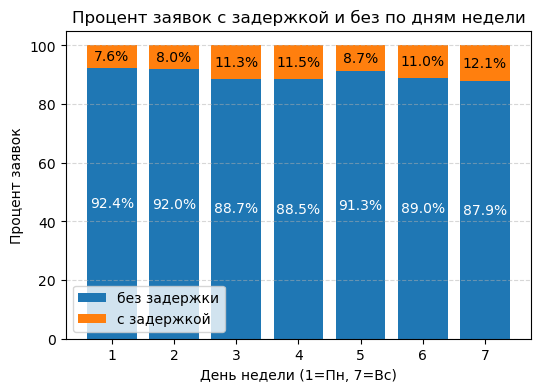

In [70]:
plt.figure(figsize=(6, 4))
plt.bar(delay_percent.index, delay_percent[False], label='без задержки')
plt.bar(delay_percent.index, delay_percent[True], bottom=delay_percent[False], label='с задержкой')

for i, value in enumerate(delay_percent[False]):
    plt.text(delay_percent.index[i], y = value / 2, s=f'{value:.1f}%', ha='center', va='center', color='white')

for i, value in enumerate(delay_percent[True]):
    bottom=delay_percent[False].iloc[i]
    plt.text(delay_percent.index[i], y = bottom + value / 2, s=f'{value:.1f}%', ha='center', va='center', color='black')

plt.xlabel('День недели (1=Пн, 7=Вс)')
plt.ylabel('Процент заявок')
plt.title('Процент заявок с задержкой и без по дням недели')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

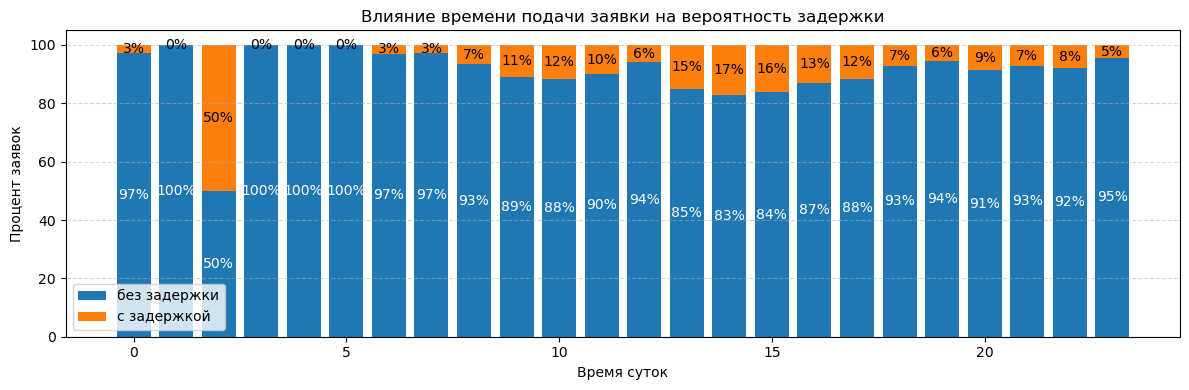

In [71]:
delay_by_time = df_final.groupby(['application_submission_time', 'with_delay']).size().unstack(fill_value=0)
delay_by_time_percent = delay_by_time.div(delay_by_time.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 4))
plt.bar(delay_by_time_percent.index, delay_by_time_percent[False], label='без задержки')
plt.bar(delay_by_time_percent.index, delay_by_time_percent[True], bottom=delay_by_time_percent[False], label='с задержкой')

for i, value in enumerate(delay_by_time_percent[False]):
    plt.text(delay_by_time_percent.index[i], y = value / 2, s=f'{value:.0f}%', ha='center', va='center', color='white')

for i, value in enumerate(delay_by_time_percent[True]):
    bottom=delay_by_time_percent[False].iloc[i]
    plt.text(delay_by_time_percent.index[i], y = bottom + value / 2, s=f'{value:.0f}%', ha='center', va='center', color='black')


plt.xlabel('Время суток')
plt.ylabel('Процент заявок')
plt.ylim(0, 105)
plt.title('Влияние времени подачи заявки на вероятность задержки')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [72]:
df_final['planned_delivery_year'] = df_final['planned_delivery_date'].dt.year
df_final['planned_delivery_month'] = df_final['planned_delivery_date'].dt.month
df_final['planned_delivery_day'] = df_final['planned_delivery_date'].dt.day
df_final['planned_delivery_weekday'] = df_final['planned_delivery_date'].dt.weekday
df_final.head(2)

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,position,material_class,delivery_date,actual_volume,application_submission_date,application_submission_time,delay_days,with_delay,delivery_weekday,planned_delivery_year,planned_delivery_month,planned_delivery_day,planned_delivery_weekday
0,2025-02-02,8,строительство жилых домов,Раствор,0.5,адаменко,спорт,поз.76,М 100,2025-02-02,0.5,2025-02-01,19,0,False,7,2025,2,2,6
1,2025-02-01,8,строительство жилых домов,Раствор,1.5,дуйсен,брик таун 1,не указано,М 100,2025-02-01,1.5,2025-02-01,7,0,False,6,2025,2,1,5


In [73]:
df_final['days_advance_submission'] = (
    df_final['planned_delivery_date'] - 
    df_final['application_submission_date']).dt.days

df_final['early_request'] = (
    (df_final['days_advance_submission'] > 0) &
    (df_final['planned_delivery_time']<= 15)
)

df_final.head(2)

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,position,material_class,delivery_date,...,application_submission_time,delay_days,with_delay,delivery_weekday,planned_delivery_year,planned_delivery_month,planned_delivery_day,planned_delivery_weekday,days_advance_submission,early_request
0,2025-02-02,8,строительство жилых домов,Раствор,0.5,адаменко,спорт,поз.76,М 100,2025-02-02,...,19,0,False,7,2025,2,2,6,1,True
1,2025-02-01,8,строительство жилых домов,Раствор,1.5,дуйсен,брик таун 1,не указано,М 100,2025-02-01,...,7,0,False,6,2025,2,1,5,0,False


In [74]:
df_final.groupby(['early_request', 'with_delay'])['object'].count()

early_request  with_delay
False          False         3256
               True           446
True           False         1777
               True           100
Name: object, dtype: int64

In [75]:
df_groupby_day = pd.DataFrame(df_final.groupby(['planned_delivery_year', 
                                                'planned_delivery_month', 
                                                'planned_delivery_day', 
                                                'planned_delivery_weekday'])['volume'].sum().reset_index())
df_mean_weekday = df_groupby_day.groupby(['planned_delivery_weekday'])['volume'].mean()
df_mean_weekday.head(50)

planned_delivery_weekday
0    225.326085
1    221.987411
2    216.130632
3    212.644203
4    181.317143
5    192.775000
6    136.906716
Name: volume, dtype: float64

In [76]:
df_groupby_day

,planned_delivery_year,planned_delivery_month,planned_delivery_day,planned_delivery_weekday,volume
0,2024,3,31,6,3.0
1,2024,4,30,1,5.0
2,2024,5,31,4,119.1
3,2024,6,7,4,288.0
4,2024,6,8,5,242.0
...,...,...,...,...,...
483,2025,10,17,4,193.5
484,2025,10,18,5,27.5
485,2025,10,19,6,134.5
486,2025,10,20,0,270.4


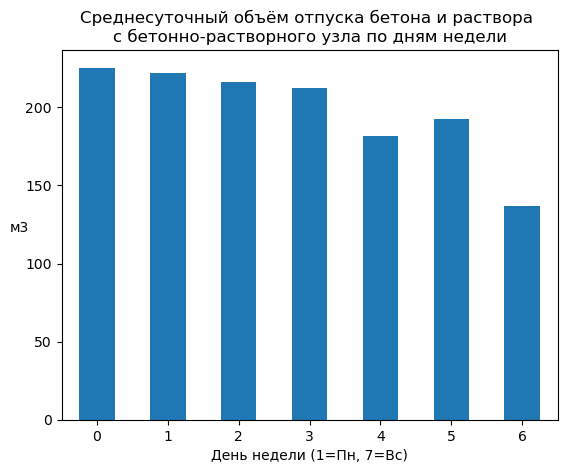

In [77]:
df_groupby_day.groupby(
    ['planned_delivery_year', 'planned_delivery_month', 
     'planned_delivery_day', 'planned_delivery_weekday']
)['volume'].sum().reset_index().groupby(['planned_delivery_weekday'])['volume'].mean().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('День недели (1=Пн, 7=Вс)')
plt.ylabel('м3', rotation=0)
plt.title('Среднесуточный объём отпуска бетона и раствора \nс бетонно-растворного узла по дням недели')
plt.show()

In [78]:
df_final.columns

Index(['planned_delivery_date', 'planned_delivery_time', 'type', 'material',
       'volume', 'full_name', 'object', 'position', 'material_class',
       'delivery_date', 'actual_volume', 'application_submission_date',
       'application_submission_time', 'delay_days', 'with_delay',
       'delivery_weekday', 'planned_delivery_year', 'planned_delivery_month',
       'planned_delivery_day', 'planned_delivery_weekday',
       'days_advance_submission', 'early_request'],
      dtype='object')

In [79]:
df_final['material_class'].unique()

array(['М 100', 'В 7,5', 'В 25 СС', 'В 25', 'В 15', 'Пескобетон М150',
       'В 30', 'М 50', 'В 22,5', 'В 20', 'Пескобетон М250',
       'Пескобетон М200', 'B 40 F 300', 'Пескобетон М100', 'В 12,5',
       'Пескобетон М350', 'В 15 СС', 'М 75', 'Пескобетон М400', 'В 20 СС',
       'В 30 СС', 'Бетон М350', 'В 22,5 СС', 'В 7,5 СС', 'В 40 F 300'],
      dtype=object)

In [81]:
interval_cols = df_final.select_dtypes(include='number').columns
phik_corr = df_final.phik_matrix(interval_cols=interval_cols)

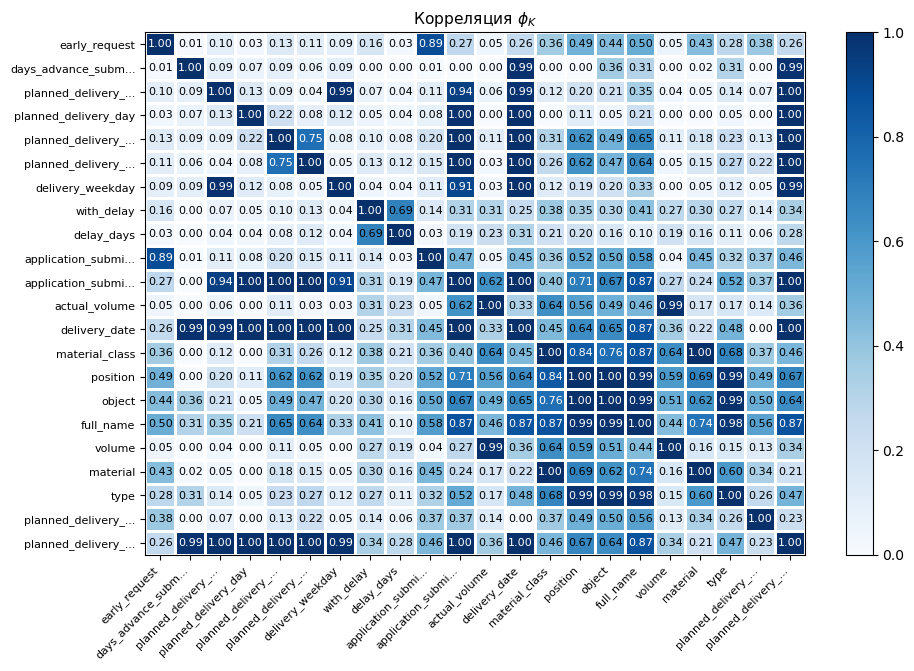

In [92]:
plot_correlation_matrix(phik_corr.values,
                        x_labels=phik_corr.columns,
                        y_labels=phik_corr.index,
                        vmin=0, vmax=1, color_map='Blues',
                        title=r'Корреляция $\phi_K$',
                        fontsize_factor=0.8,
                        figsize=(12, 8))
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3, left=0.3)
plt.show()

In [ ]:
correlation_with_target = df_ready.corr(numeric_only=True)['delay'].sort_values(ascending=False).drop('delay')

plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
plt.title('Корреляция признаков с таргетом')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

In [ ]:
X = df_ready.drop(columns= 'delay', axis=1)
y = df_ready['delay']

In [ ]:
num_col = X.select_dtypes(include='number').columns
cat_col = X.select_dtypes(exclude='number').columns
print(num_col)
print(cat_col)

In [ ]:
num_transform = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [ ]:
cat_transform = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transform, num_col),
    ('cat', cat_transform, cat_col)
])

In [ ]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [ ]:
param_grid = [
    {
        'classifier' : [LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)],
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__max_iter' : [100, 200]
    },
    {
        'classifier' : [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators' : [200, 500],
        'classifier__max_depth' : [10, 20], #50],
        # 'classifier__min_samples_split' : [5, 7, 12]
    },
    {
        'classifier' : [LGBMClassifier(random_state=42)],
        'classifier__scale_pos_weight': [1, 2],# 5],
        'classifier__n_estimators': [500, 1000],# 1700],
    #     'classifier__max_depth': [5, 10, 15],
    #     'classifier__learning_rate': [0.01, 0.1],
    #     'classifier__num_leaves': [5, 10, 12]
     }
]

In [ ]:
grid_search = GridSearchCV(clf, 
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train.columns

In [ ]:
X_test.info()

In [ ]:
# grid_search.fit(X_train, y_train)

In [ ]:
best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

In [ ]:
threshold = 0.35
y_pred = (y_proba >= threshold).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['без задержки', 'с задержкой'])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(cmap='Blues', ax=ax)
ax.set_ylabel('Фактический класс')
ax.set_xlabel('Предсказанный класс')
ax.set_yticklabels(['без задержки', 'с задержкой'], rotation=90, va='center')
plt.show()

In [ ]:
print('Accuracy - доля правильных предсказаний:', accuracy_score(y_test, y_pred))
print('Precision - сколько из предсказанных 1 действительно 1:', precision_score(y_test, y_pred))
print('Recall - сколько из настоящих 1 нашли:', recall_score(y_test, y_pred))
print('F1-score - гармония между precision и recall:', f1_score(y_test, y_pred))
print('ROC auc - общая способность модели отделять классы:', roc_auc_score(y_test, y_pred))